In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score, completeness_score
import itertools
import time

In [12]:

N_CLUSTERS = 8

In [13]:
# === FUNCIONES AUXILIARES ===
def fourier(spike_train, a):

    multiples = np.arange(1, len(a)+1)
    # Compute sin(pi * spike_train[i] * multiples[j]) as a matrix
    sin_matrix = np.sin(np.pi * np.outer(spike_train, multiples)) # Shape (n, k)

    # Multiply each column by a[j] (broadcasting over columns)
    weighted_matrix = sin_matrix * a

    # Sum all elements to get the final scalar
    total_sum = np.sum(weighted_matrix)
    return   total_sum 


def fourier_dist(st1, st2, a):
    s1 = fourier(st1, a)
    s2 = fourier(st2, a)
    return np.abs(s1 - s2)

In [14]:
# === CARGAR DATOS ===
data=pd.read_csv(r'C:\Users\tomys\OneDrive - Universidad Adolfo Ibanez\repositorio\clustering\resultados_pipeline_20250425_070339\spike_trains.csv')
filters = data["filter"]
spike_trains = data.drop(columns=["filter"]).apply(lambda row: row.dropna().to_numpy(), axis=1)
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(filters)

In [6]:
    # Crear matriz de distancias
n = len(spike_trains)
dist_matrix = np.zeros((n, n))
a=np.array([1,3,-2,-1,1])
for i in range(n):
    for j in range(i+1, n):
        d = fourier_dist(spike_trains.iloc[i], spike_trains.iloc[j], a)
        dist_matrix[i, j] = d
        dist_matrix[j, i] = d

In [7]:
condensed = dist_matrix[np.triu_indices(n, k=1)]
linked = linkage(condensed, method="ward")
clusters = fcluster(linked, t=N_CLUSTERS, criterion="maxclust")

# Evaluación
ari = adjusted_rand_score(true_labels, clusters)
ami = adjusted_mutual_info_score(true_labels, clusters)
fmi = fowlkes_mallows_score(true_labels, clusters)
completeness = completeness_score(true_labels, clusters)


In [20]:
resultados=[ari,ami,fmi,completeness]
resultados=np.array(resultados)

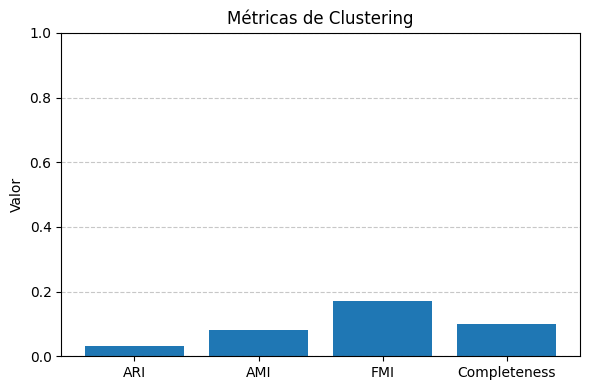

In [28]:
import matplotlib.pyplot as plt

nombres = ["ARI", "AMI", "FMI", "Completeness"]

# Crear gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(nombres, resultados)
plt.ylim(0, 1)  # Si tus valores están entre 0 y 1
plt.title("Métricas de Clustering")
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:

# Cargar el CSV
df = pd.read_csv("resultados_gridsearch6.csv")

# Filtrar solo la mejor combinación (primer lugar según ARI)
top1 = df.sort_values("ARI", ascending=False).head(1)

# Formatear nombre para el gráfico
top1_label = f"a1={top1['a1'].values[0]:.1f}, a2={top1['a2'].values[0]:.1f}, a3={top1['a3'].values[0]:.1f}"

# Preparar DataFrame para graficar
top1_metrics = top1[["ARI", "AMI", "FMI", "Completeness"]].T
top1_metrics.columns = [top1_label]

# Graficar solo una barra por métrica
plt.figure(figsize=(8, 5))
top1_metrics.plot(kind="bar", legend=True, colormap="Pastel1")
plt.title(f"Evaluacion cluster fourier\n{top1_label}")
plt.ylabel("Valor")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.grid(axis="y")

plt.savefig("metricas_parametros.png")
plt.show()


In [ ]:
resultados.append({
        "a1": a1,
        "a2": a2,
        "a3": a3,
        "ARI": ari,
        "AMI": ami,
        "FMI": fmi,
        "Completeness": completeness
    })

In [ ]:
# === INICIAR BÚSQUEDA ===
resultados = []
start_time = time.time()

for a1, a2, a3 in itertools.product(VALORES, VALORES, VALORES):
    # Crear matriz de distancias
    n = len(spike_trains)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = fourier_dist(spike_trains.iloc[i], spike_trains.iloc[j], a)
            dist_matrix[i, j] = d
            dist_matrix[j, i] = d

    # Clustering jerárquico
    condensed = dist_matrix[np.triu_indices(n, k=1)]
    linked = linkage(condensed, method="ward")
    clusters = fcluster(linked, t=N_CLUSTERS, criterion="maxclust")

    # Evaluación
    ari = adjusted_rand_score(true_labels, clusters)
    ami = adjusted_mutual_info_score(true_labels, clusters)
    fmi = fowlkes_mallows_score(true_labels, clusters)
    completeness = completeness_score(true_labels, clusters)

    resultados.append({
        "a1": a1,
        "a2": a2,
        "a3": a3,
        "ARI": ari,
        "AMI": ami,
        "FMI": fmi,
        "Completeness": completeness
    })

In [40]:


# === GUARDAR Y MOSTRAR RESULTADOS ===
resultados_df = pd.DataFrame(resultados)
resultados_df.sort_values("ARI", ascending=False, inplace=True)
resultados_df.to_csv("resultados_gridsearch6.csv", index=False)

print("Top 10 combinaciones:")
print(resultados_df.head(10))



Top 10 combinaciones:
     a1   a2  a3       ARI       AMI       FMI  Completeness
21  100   50  10  0.132323  0.268841  0.242447      0.281609
18  100   10  10  0.130526  0.268486  0.251104      0.288092
9    50   10  10  0.122160  0.261539  0.236568      0.276659
24  100  100  10  0.119161  0.249944  0.236982      0.266757
12   50   50  10  0.113465  0.251039  0.237950      0.271502
19  100   10  50  0.113277  0.226325  0.228355      0.241011
25  100  100  50  0.106434  0.224360  0.228527      0.242747
22  100   50  50  0.105360  0.230248  0.225944      0.248194
15   50  100  10  0.097915  0.199285  0.221531      0.217825
13   50   50  50  0.088061  0.177713  0.208312      0.193507


<Figure size 800x500 with 0 Axes>

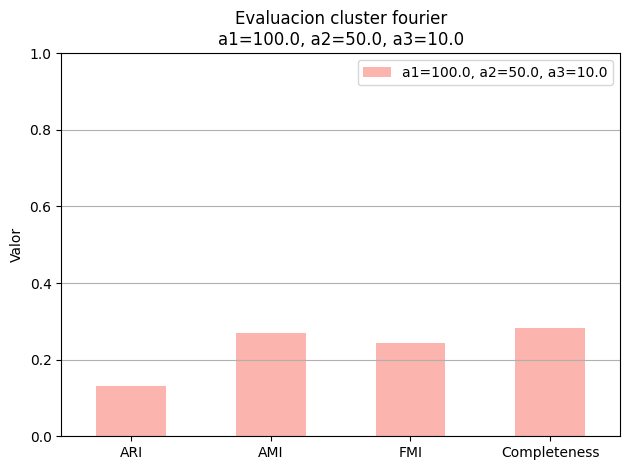

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el CSV
df = pd.read_csv("resultados_gridsearch6.csv")

# Filtrar solo la mejor combinación (primer lugar según ARI)
top1 = df.sort_values("ARI", ascending=False).head(1)

# Formatear nombre para el gráfico
top1_label = f"a1={top1['a1'].values[0]:.1f}, a2={top1['a2'].values[0]:.1f}, a3={top1['a3'].values[0]:.1f}"

# Preparar DataFrame para graficar
top1_metrics = top1[["ARI", "AMI", "FMI", "Completeness"]].T
top1_metrics.columns = [top1_label]

# Graficar solo una barra por métrica
plt.figure(figsize=(8, 5))
top1_metrics.plot(kind="bar", legend=True, colormap="Pastel1")
plt.title(f"Evaluacion cluster fourier\n{top1_label}")
plt.ylabel("Valor")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.grid(axis="y")

plt.savefig("metricas_parametros.png")
plt.show()
